In [23]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

## Dataset Stats

In [ ]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [ ]:
dataset_dir = 'Dataset'
mean, std = calculate_dataset_stats(dataset_dir)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

assert abs(mean[0]*255 - 0.57119 * 255) < 0.1, "Red mean mismatch"
assert abs(mean[1]*255 - 0.57445 * 255) < 0.1, "Green mean mismatch"
assert abs(mean[2]*255 - 0.60537 * 255) < 0.1, "Blue mean mismatch"

assert abs(std[0]*255 - 0.11762 * 255) < 0.1, "Red std mismatch"
assert abs(std[1]*255 - 0.12342 * 255) < 0.1, "Green std mismatch"
assert abs(std[2]*255 - 0.11999 * 255) < 0.1, "Blue std mismatch"

print("\nBasic validation checks passed!")

In [24]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]

imageNet_mean = [0.485, 0.456, 0.406]
imageNet_std = [0.229, 0.224, 0.225]

## Traffic Sign Dataset

### Data Augmentation

In [25]:
transform_album = A.Compose(
    [   
        A.Resize(32, 32),
        A.Affine(
            translate_percent=0.02,
            scale=(0.95, 1.05),
            fill=128,
            p=0.3
        ),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            fill=128,
            p=0.4
        ),
        # A.HueSaturationValue(
        #     hue_shift_limit=2,
        #     sat_shift_limit=3,
        #     val_shift_limit=3,
        #     p=0.2
        # ),
        A.RandomBrightnessContrast(
            brightness_limit=(0, 0.2),
            contrast_limit=0.1,
            p=0.2
        ),
        A.RGBShift(
          r_shift_limit=2,
          g_shift_limit=2,
          b_shift_limit=2,
          p=0.2 
        ),
        A.GaussianBlur(
            blur_limit=(3, 7),
            p=0.2
        ),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            mean_range=(0.04, 0.06),
            p=0.2
        ),
        # A.CoarseDropout(
        #     num_holes_range=(1, 2),
        #     hole_height_range=(4, 6),
        #     hole_width_range=(4, 6),
        #     fill=128,
        #     p=0.2
        # ),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [26]:
transform_simple = A.Compose(
    [
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [27]:
transform_resize = A.Compose(
    [
        A.Resize(32, 32),
        ToTensorV2()
    ],
    p=1
)

In [28]:
root_dir = r'Dataset'
output_dir = r'Augmented_Dataset'
os.makedirs(output_dir, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [29]:
class_idx

{0: 'barred_area',
 1: 'cross_walk',
 2: 'go_straight',
 3: 'no_passing_zone_beginning',
 4: 'parking_zone',
 5: 'priority_over',
 6: 'steep_hill_downhill',
 7: 'steep_hill_uphill',
 8: 'stop',
 9: 'tunnel_beginning',
 10: 'turn_left',
 11: 'turn_right'}

In [38]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(output_dir, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(output_dir, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(output_dir)}")

Augmenting Images: 100%|██████████| 33595/33595 [03:17<00:00, 170.05img/s, Processing: turn_right/frame_0573_aug_05.png]               



Augmentation complete. 6719 → 33595 files
Augmented images saved in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Augmented_Dataset


In [10]:
images_path_list = []
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir)}")

Processing Images: 100%|██████████| 6719/6719 [02:07<00:00, 52.65img/s]


Processing complete. 6719 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset


### Dataset Class

In [30]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self) -> int:
        return len(self.images_path_list)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [31]:
root_dir_dataset = r'Dataset'
root_dir_augmented = r'Augmented_Dataset'

train_percentage = 0.2

images_path_list_train = []
labels_path_list_train = []
images_path_list_test = []
labels_path_list_test = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Augmented images (training)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    for img_path in aug_images_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (training and testing)
    orig_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    orig_images_paths = sorted(glob.glob(orig_pattern))
    
    train_paths, test_paths = train_test_split(
        orig_images_paths,
        train_size=train_percentage,
        random_state=42,
        shuffle=True
    )
    
    for img_path in train_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)
        
    for img_path in test_paths:
        images_path_list_test.append(img_path)
        labels_path_list_test.append(cls_idx)

In [32]:
train_dataset = TrafficSignDB(
    images_path_list=images_path_list_train,
    labels_path_list=labels_path_list_train,
    transform=transform_simple
)

test_dataset = TrafficSignDB(
    images_path_list=images_path_list_test,
    labels_path_list=labels_path_list_test,
    transform=transform_simple
)

In [33]:
print("Class Mapping (idx -> class):")
print(train_dataset.idx_to_class)
print("\nTrain Dataset Files:")
for path, label in zip(images_path_list_train, labels_path_list_train):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")
print("\nTest Dataset Files:")
for path, label in zip(images_path_list_test, labels_path_list_test):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")

Class Mapping (idx -> class):
{0: 'barred_area', 1: 'cross_walk', 2: 'go_straight', 3: 'no_passing_zone_beginning', 4: 'parking_zone', 5: 'priority_over', 6: 'steep_hill_downhill', 7: 'steep_hill_uphill', 8: 'stop', 9: 'tunnel_beginning', 10: 'turn_left', 11: 'turn_right'}

Train Dataset Files:
Path: Augmented_Dataset\barred_area\frame_0001_aug_01.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_02.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_03.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_04.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_05.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_01.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_02.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_03.png | Label: 0 | Cla

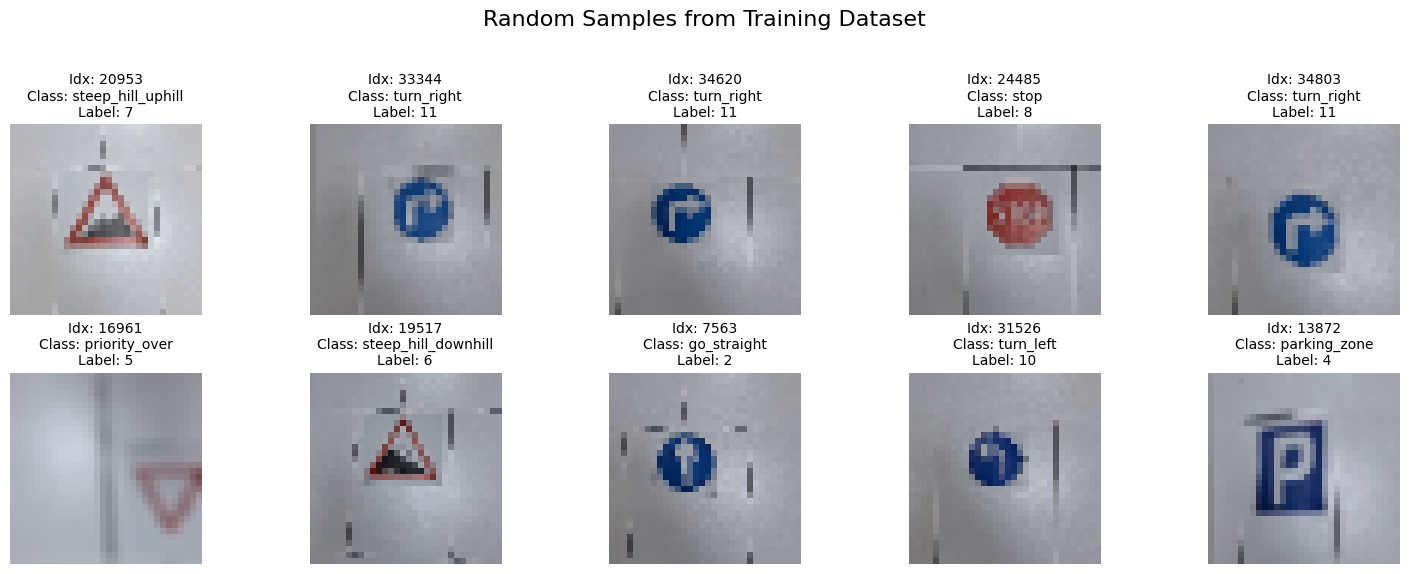

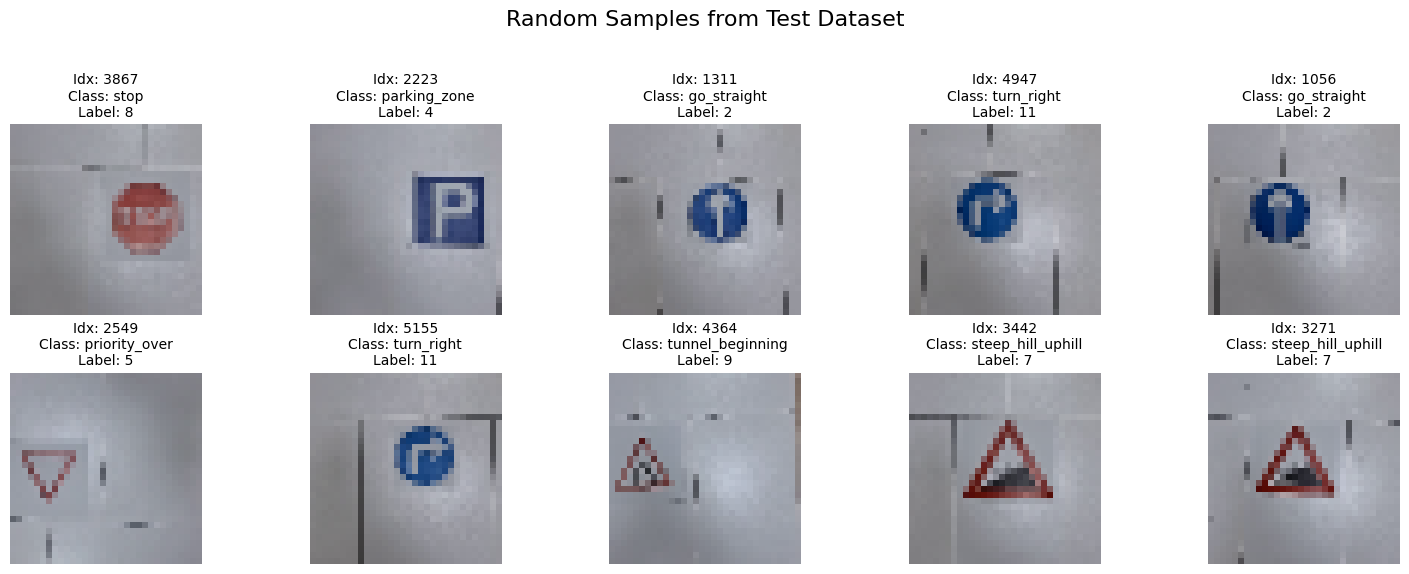

In [34]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def show_random_samples_subplot(dataset, num_samples=10, dataset_name="Dataset"):
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        class_name = dataset.get_class_name(label)
        if isinstance(image, torch.Tensor):
            image = denormalize_image(image, dataset_mean, dataset_std)
        axes[i].imshow(image)
        axes[i].set_title(f"Idx: {idx}\nClass: {class_name}\nLabel: {label}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f"Random Samples from {dataset_name}", fontsize=16)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95), w_pad=2)
    plt.show()

show_random_samples_subplot(train_dataset, num_samples=10, dataset_name="Training Dataset")
show_random_samples_subplot(test_dataset, num_samples=10, dataset_name="Test Dataset")

In [35]:
from collections import Counter

train_class_counts = Counter(labels_path_list_train)
test_class_counts = Counter(labels_path_list_test)
train_total = len(images_path_list_train)
test_total = len(images_path_list_test)

print("\nTraining Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = train_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")

print("\nTest Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = test_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")
    
print(f"\nTraining Dataset Size: {train_total} samples")
print(f"Test Dataset Size: {test_total} samples")
print(f"Total Combined Size: {train_total + test_total} samples")


Training Dataset Class Distribution:
Class 'barred_area' (Index 0): 3255 samples
Class 'cross_walk' (Index 1): 3114 samples
Class 'go_straight' (Index 2): 2646 samples
Class 'no_passing_zone_beginning' (Index 3): 2990 samples
Class 'parking_zone' (Index 4): 2615 samples
Class 'priority_over' (Index 5): 3073 samples
Class 'steep_hill_downhill' (Index 6): 2355 samples
Class 'steep_hill_uphill' (Index 7): 2626 samples
Class 'stop' (Index 8): 2953 samples
Class 'tunnel_beginning' (Index 9): 3218 samples
Class 'turn_left' (Index 10): 3109 samples
Class 'turn_right' (Index 11): 2979 samples

Test Dataset Class Distribution:
Class 'barred_area' (Index 0): 501 samples
Class 'cross_walk' (Index 1): 480 samples
Class 'go_straight' (Index 2): 408 samples
Class 'no_passing_zone_beginning' (Index 3): 460 samples
Class 'parking_zone' (Index 4): 403 samples
Class 'priority_over' (Index 5): 473 samples
Class 'steep_hill_downhill' (Index 6): 363 samples
Class 'steep_hill_uphill' (Index 7): 404 samples

## Training the Model

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3859543..1.6792909].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.0685987..1.4275512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.297605..1.5792168].



Dataset Verification:
Total samples: 34933
Sample paths: ['Augmented_Dataset\\barred_area\\frame_0001_aug_01.png', 'Augmented_Dataset\\barred_area\\frame_0001_aug_02.png', 'Augmented_Dataset\\barred_area\\frame_0001_aug_03.png']


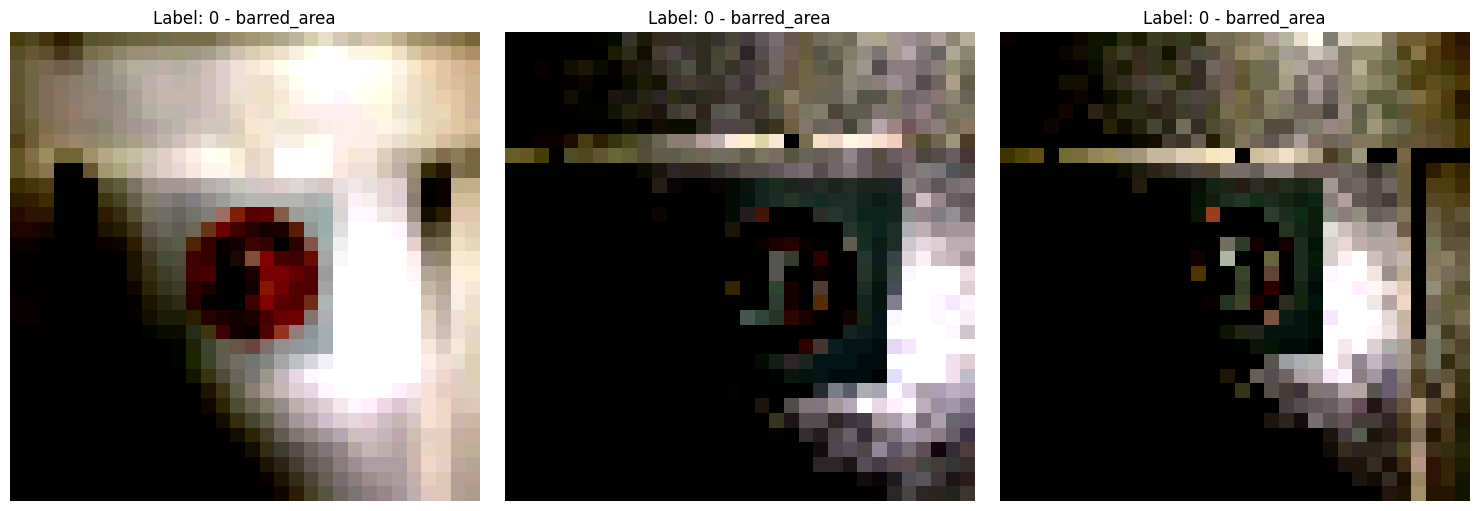

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4797258..1.4602664].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8864784..1.5792168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1852891..1.394836].



Dataset Verification:
Total samples: 5381
Sample paths: ['Dataset\\barred_area\\frame_0449.png', 'Dataset\\barred_area\\frame_0487.png', 'Dataset\\barred_area\\frame_0216.png']


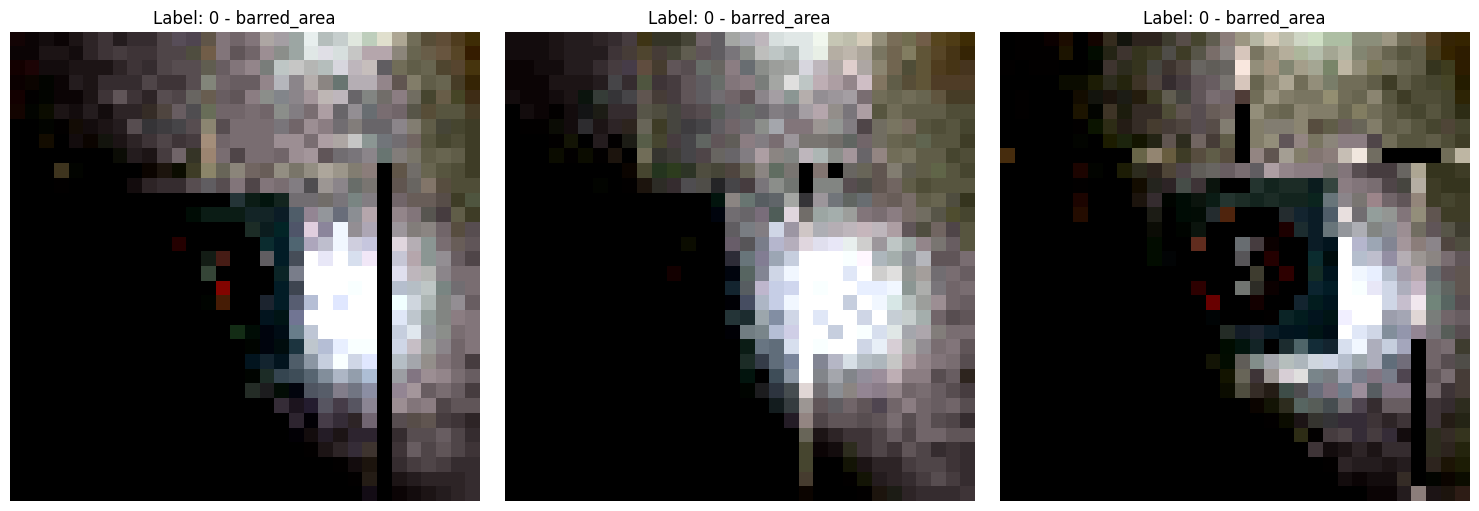

In [37]:
def verify_dataset(dataset, num_samples=3):
    print("\nDataset Verification:")
    print(f"Total samples: {len(dataset)}")
    print(f"Sample paths: {dataset.images_path_list[:3]}")
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title(f"Label: {label} - {dataset.get_class_name(label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

verify_dataset(train_dataset)
verify_dataset(test_dataset)

In [38]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(TrafficSignCNN, self).__init__()
        
        self.conv0 = nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=1, padding=0)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        
        self.dropout = nn.Dropout(0.5)

        flattened_size = 8192 + 4096 + 2048
        
        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        print(f"Input shape: {x.shape}") if self.training else None
        
        x = F.relu(self.conv0(x))

        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))
        x2 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,32,16,16)
        x2 = self.dropout(x2)
        

        x = F.relu(self.conv3(x2))

        x = F.relu(self.conv4(x))
        x4 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,64,8,8)
        x4 = self.dropout(x4)
        
        x = F.relu(self.conv5(x4))

        x = F.relu(self.conv6(x))
        x6 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,128,4,4)
        x6 = self.dropout(x6)
        
        flat2 = x2.view(x2.size(0), -1)
        flat4 = x4.view(x4.size(0), -1)
        flat6 = x6.view(x6.size(0), -1)
        
        x_concat = torch.cat((flat2, flat4, flat6), dim=1)  # (B, 14336)
        
        x = F.relu(self.fc1(x_concat))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)
        
        return logits

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [23]:
num_classes = len(class_names)
model = TrafficSignCNN(num_classes=num_classes, input_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [19]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i ,(inputs, labels) in enumerate(train_loader):
        print(f"Batch {i+1}")
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f}", flush=True)
    
    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Accuracy: {val_acc:.4f}")

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 11

KeyboardInterrupt: 

In [40]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(dataloader.dataset), correct / total

In [41]:
def check_dimensions(loader):
    for inputs, _ in loader:
        print(f"Batch dimensions: {inputs.shape}")
        print(f"Data range: {inputs.min().item()} - {inputs.max().item()}")
        break

print("\nChecking training data dimensions:")
check_dimensions(train_loader)
print("\nChecking validation data dimensions:")
check_dimensions(test_loader)


Checking training data dimensions:
Batch dimensions: torch.Size([32, 3, 32, 32])
Data range: -4.984623908996582 - 2.7361583709716797

Checking validation data dimensions:
Batch dimensions: torch.Size([32, 3, 32, 32])
Data range: -5.01733922958374 - 1.846081018447876


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    writer = SummaryWriter()  # TensorBoard logging
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # Create one progress bar for the epoch
        tepoch = tqdm(
            train_loader,
            unit="batch",
            leave=True,
            desc=f"Epoch {epoch+1}/{num_epochs}",
            # dynamic_ncols=True,
            ncols=100,
            bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
        )
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            tepoch.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100.*correct/total:.2f}")
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        
        val_loss, val_acc = evaluate_model(model, criterion, test_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    writer.close()
    return model

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)
model = TrafficSignCNN(num_classes=num_classes, input_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10:   0%|           | 0/1092 [00:00<?, ?batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   0%|           | 3/1092 [00:00<03:34,  5.09batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   0%|           | 5/1092 [00:00<03:04,  5.90batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   1%|           | 7/1092 [00:01<02:27,  7.36batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   1%|           | 9/1092 [00:01<02:20,  7.73batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   1%|           | 11/1092 [00:01<02:12,  8.16batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   1%|           | 13/1092 [00:01<02:24,  7.45batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   1%|▏          | 14/1092 [00:02<02:34,  6.97batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   1%|▏          | 16/1092 [00:02<02:39,  6.75batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   2%|▏          | 19/1092 [00:02<02:26,  7.30batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   2%|▏          | 20/1092 [00:03<02:36,  6.87batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   2%|▏          | 22/1092 [00:03<02:36,  6.86batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   2%|▏          | 25/1092 [00:03<02:42,  6.58batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   2%|▏          | 26/1092 [00:03<02:42,  6.55batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   3%|▎          | 28/1092 [00:04<02:57,  6.01batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   3%|▎          | 30/1092 [00:04<03:10,  5.58batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   3%|▎          | 32/1092 [00:04<02:59,  5.92batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   3%|▎          | 34/1092 [00:05<02:52,  6.12batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   3%|▎          | 36/1092 [00:05<02:52,  6.14batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   3%|▎          | 38/1092 [00:05<02:54,  6.03batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   4%|▎          | 40/1092 [00:06<02:49,  6.21batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   4%|▍          | 42/1092 [00:06<02:56,  5.95batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   4%|▍          | 43/1092 [00:06<03:07,  5.61batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   4%|▍          | 45/1092 [00:07<03:05,  5.65batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   4%|▍          | 47/1092 [00:07<02:56,  5.91batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   4%|▍          | 49/1092 [00:07<03:00,  5.77batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   5%|▍          | 51/1092 [00:08<03:13,  5.39batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   5%|▍          | 53/1092 [00:08<03:02,  5.70batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   5%|▌          | 55/1092 [00:08<03:02,  5.68batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   5%|▌          | 57/1092 [00:09<02:55,  5.91batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   5%|▌          | 59/1092 [00:09<02:58,  5.78batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   6%|▌          | 61/1092 [00:09<02:56,  5.83batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   6%|▌          | 63/1092 [00:10<02:56,  5.84batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   6%|▌          | 65/1092 [00:10<02:53,  5.90batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   6%|▌          | 67/1092 [00:10<03:03,  5.59batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   6%|▌          | 68/1092 [00:11<03:13,  5.28batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   6%|▋          | 70/1092 [00:11<03:10,  5.36batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   7%|▋          | 72/1092 [00:12<03:06,  5.46batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   7%|▋          | 74/1092 [00:12<02:52,  5.90batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   7%|▋          | 76/1092 [00:12<02:47,  6.05batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   7%|▋          | 77/1092 [00:12<03:05,  5.47batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   7%|▋          | 79/1092 [00:13<02:53,  5.83batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   7%|▋          | 81/1092 [00:13<02:42,  6.20batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   8%|▊          | 84/1092 [00:13<02:40,  6.27batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   8%|▊          | 85/1092 [00:14<02:44,  6.13batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   8%|▊          | 87/1092 [00:14<02:51,  5.85batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   8%|▊          | 89/1092 [00:14<02:44,  6.09batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   8%|▊          | 91/1092 [00:15<02:51,  5.82batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   9%|▊          | 93/1092 [00:15<03:03,  5.45batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   9%|▊          | 95/1092 [00:15<02:50,  5.84batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   9%|▉          | 97/1092 [00:16<02:44,  6.03batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   9%|▉          | 99/1092 [00:16<02:48,  5.90batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   9%|▉          | 101/1092 [00:16<02:55,  5.65batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:   9%|▉          | 103/1092 [00:17<02:40,  6.17batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  10%|▉          | 105/1092 [00:17<02:33,  6.41batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  10%|▉          | 107/1092 [00:17<02:33,  6.43batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  10%|▉          | 109/1092 [00:18<02:53,  5.67batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  10%|█          | 111/1092 [00:18<02:55,  5.59batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  10%|█          | 113/1092 [00:18<02:48,  5.80batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  11%|█          | 115/1092 [00:19<02:55,  5.55batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  11%|█          | 117/1092 [00:19<02:43,  5.98batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  11%|█          | 119/1092 [00:20<02:49,  5.73batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  11%|█          | 121/1092 [00:20<02:36,  6.21batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  11%|█          | 122/1092 [00:20<02:54,  5.56batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  11%|█▏         | 124/1092 [00:20<02:40,  6.02batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  12%|█▏         | 126/1092 [00:21<02:32,  6.33batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  12%|█▏         | 128/1092 [00:21<02:37,  6.11batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  12%|█▏         | 131/1092 [00:21<02:30,  6.39batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  12%|█▏         | 132/1092 [00:22<02:31,  6.33batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  12%|█▏         | 134/1092 [00:22<02:18,  6.90batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  12%|█▏         | 136/1092 [00:22<02:25,  6.58batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  13%|█▎         | 138/1092 [00:22<02:37,  6.05batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  13%|█▎         | 139/1092 [00:23<02:48,  5.65batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  13%|█▎         | 141/1092 [00:23<02:42,  5.84batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  13%|█▎         | 143/1092 [00:23<02:33,  6.19batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  13%|█▎         | 145/1092 [00:24<02:42,  5.82batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  13%|█▎         | 147/1092 [00:24<02:40,  5.90batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  14%|█▎         | 150/1092 [00:24<02:26,  6.44batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  14%|█▍         | 151/1092 [00:25<02:30,  6.26batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  14%|█▍         | 153/1092 [00:25<02:29,  6.30batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  14%|█▍         | 155/1092 [00:25<02:35,  6.04batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  14%|█▍         | 157/1092 [00:26<02:43,  5.71batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  14%|█▍         | 158/1092 [00:26<02:56,  5.29batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  15%|█▍         | 159/1092 [00:26<03:00,  5.18batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  15%|█▍         | 161/1092 [00:26<02:52,  5.39batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  15%|█▍         | 163/1092 [00:27<02:55,  5.30batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  15%|█▌         | 165/1092 [00:27<02:39,  5.80batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  15%|█▌         | 167/1092 [00:27<02:52,  5.37batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  15%|█▌         | 169/1092 [00:28<02:35,  5.92batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  16%|█▌         | 171/1092 [00:28<02:38,  5.82batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  16%|█▌         | 173/1092 [00:28<02:38,  5.81batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  16%|█▌         | 175/1092 [00:29<02:48,  5.44batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  16%|█▌         | 177/1092 [00:29<02:40,  5.70batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  16%|█▋         | 179/1092 [00:30<02:31,  6.01batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  17%|█▋         | 182/1092 [00:30<02:16,  6.64batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  17%|█▋         | 183/1092 [00:30<02:19,  6.53batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  17%|█▋         | 185/1092 [00:30<02:30,  6.04batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  17%|█▋         | 187/1092 [00:31<02:27,  6.15batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  17%|█▋         | 189/1092 [00:31<02:21,  6.40batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  17%|█▋         | 191/1092 [00:31<02:17,  6.54batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  18%|█▊         | 192/1092 [00:32<02:29,  6.03batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  18%|█▊         | 194/1092 [00:32<02:23,  6.25batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  18%|█▊         | 196/1092 [00:32<02:27,  6.08batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  18%|█▊         | 198/1092 [00:33<02:24,  6.17batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  18%|█▊         | 200/1092 [00:33<02:24,  6.17batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  18%|█▊         | 202/1092 [00:33<02:27,  6.04batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  19%|█▊         | 204/1092 [00:34<02:26,  6.05batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  19%|█▉         | 206/1092 [00:34<02:38,  5.60batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  19%|█▉         | 208/1092 [00:34<02:43,  5.42batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  19%|█▉         | 210/1092 [00:35<02:30,  5.86batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  19%|█▉         | 212/1092 [00:35<02:25,  6.03batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  20%|█▉         | 214/1092 [00:35<02:39,  5.52batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  20%|█▉         | 216/1092 [00:36<02:31,  5.78batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  20%|█▉         | 218/1092 [00:36<02:26,  5.95batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  20%|██         | 220/1092 [00:36<02:22,  6.10batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  20%|██         | 222/1092 [00:37<02:16,  6.37batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  21%|██         | 224/1092 [00:37<02:20,  6.20batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  21%|██         | 226/1092 [00:37<02:37,  5.49batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  21%|██         | 228/1092 [00:38<02:33,  5.62batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  21%|██         | 230/1092 [00:38<02:42,  5.31batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  21%|██         | 232/1092 [00:38<02:40,  5.37batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/10:  21%|██▏        | 234/1092 [00:39<02:28,  5.79batch/s]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Input shape: torch.Size([32, 3, 32, 32])


KeyboardInterrupt: 

## Validation

In [ ]:
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

In [ ]:
class_names = [
    'barred_area',
    'cross_walk',
    'go_straight',
    'no_passing_zone_beginning',
    'parking_zone',
    'priority_over',
    'steep_hill_downhill',
    'steep_hill_uphill',
    'stop',
    'tunnel_beginning',
    'turn_left',
    'turn_right'
]

In [ ]:
def live_test(model_path):
    # Load model
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path))
    model.eval().to(device)
    
    # Define proper transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL first
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imageNet_mean, std=imageNet_std)
    ])
    
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        # Convert to RGB and process
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        tensor_img = transform(rgb).unsqueeze(0).to(device)  # No 'image=' keyword
        
        # Inference
        with torch.no_grad():
            outputs = model(tensor_img)
            _, pred = torch.max(outputs, 1)
            sign_name = class_names[pred.item()]
        
        # Display
        cv2.putText(frame, sign_name, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Detection', frame)
        
        if cv2.waitKey(1) == ord('q'): break
    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
live_test("traffic_sign_cnn.pth")